In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fbprophet import Prophet
import matplotlib.pyplot as plt
import math as math
import tsod
%matplotlib inline

from fbprophet import Prophet
import pickle

In [3]:
# Load the data
data = pd.read_csv("20220929/queinfo_20220929.csv")

In [20]:
data.head()

,rsid,name,cnt_item,is_pending,insert_date_time
0,unirs01,recv_smt_slow.que,0,0,2022-09-29 00:00:01
1,unirs01,recv_mmt_slow.que,0,0,2022-09-29 00:00:01
2,unirs01,recv_smt_fast.que,0,0,2022-09-29 00:00:01
3,unirs01,recv_mmt_fast.que,0,0,2022-09-29 00:00:01
4,unirs01,dbmtfail.que,0,0,2022-09-29 00:00:01


In [4]:
data.groupby(["rsid", "insert_date_time"], as_index=False).sum()
data

,rsid,name,cnt_item,is_pending,insert_date_time
0,unirs01,recv_smt_slow.que,0,0,2022-09-29 00:00:01
1,unirs01,recv_mmt_slow.que,0,0,2022-09-29 00:00:01
2,unirs01,recv_smt_fast.que,0,0,2022-09-29 00:00:01
3,unirs01,recv_mmt_fast.que,0,0,2022-09-29 00:00:01
4,unirs01,dbmtfail.que,0,0,2022-09-29 00:00:01
...,...,...,...,...,...
155515,wngrs01,dbmt6.que,2,0,2022-09-29 23:59:03
155516,wngrs01,dbmtfail.que,0,0,2022-09-29 23:59:03
155517,wngrs02,dbmtfail.que,0,0,2022-09-29 23:59:03
155518,rcsrs01,recv_mmt_fast.que,0,0,2022-09-29 23:59:03


In [17]:
cnt_item_data1 = data.groupby(["insert_date_time"], as_index=False).sum()
cnt_item_data1.head(50)

,insert_date_time,cnt_item,is_pending
0,2022-09-29 00:00:01,3,0
1,2022-09-29 00:00:02,6,0
2,2022-09-29 00:01:01,4,0
3,2022-09-29 00:01:02,5,0
4,2022-09-29 00:02:01,4,0
5,2022-09-29 00:03:01,9,0
6,2022-09-29 00:04:01,6,0
7,2022-09-29 00:04:02,2,0
8,2022-09-29 00:05:01,3,0
9,2022-09-29 00:05:02,3,0


In [7]:
cnt_item_data1.value_counts()

insert_date_time     cnt_item  is_pending
2022-09-29 00:00:01  3         0             1
2022-09-29 16:33:04  3         0             1
2022-09-29 16:35:05  5         0             1
2022-09-29 16:35:03  3         0             1
2022-09-29 16:35:01  52        1             1
                                            ..
2022-09-29 08:56:03  0         0             1
2022-09-29 08:56:04  2         1             1
2022-09-29 08:57:01  43        0             1
2022-09-29 08:57:02  2         0             1
2022-09-29 23:59:03  4         1             1
Length: 4558, dtype: int64

In [10]:
cnt_item_data1.isnull().sum()

insert_date_time    0
cnt_item            0
is_pending          0
dtype: int64

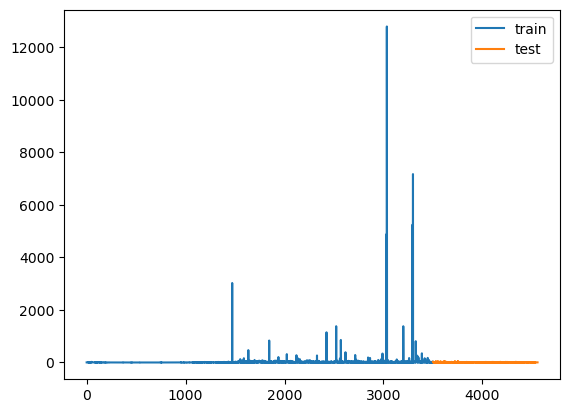

In [8]:
train = cnt_item_data1.loc[:3500, ['cnt_item']]
test = cnt_item_data1.loc[3500:, ['cnt_item']]
# Feature는 Unadjusted 한 개

ax = train.plot()
test.plot(ax=ax)

plt.legend(['train', 'test'])

In [33]:
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor 

In [23]:
data

,rsid,name,cnt_item,is_pending,insert_date_time
0,unirs01,recv_smt_slow.que,0,0,2022-09-29 00:00:01
1,unirs01,recv_mmt_slow.que,0,0,2022-09-29 00:00:01
2,unirs01,recv_smt_fast.que,0,0,2022-09-29 00:00:01
3,unirs01,recv_mmt_fast.que,0,0,2022-09-29 00:00:01
4,unirs01,dbmtfail.que,0,0,2022-09-29 00:00:01
...,...,...,...,...,...
155515,wngrs01,dbmt6.que,2,0,2022-09-29 23:59:03
155516,wngrs01,dbmtfail.que,0,0,2022-09-29 23:59:03
155517,wngrs02,dbmtfail.que,0,0,2022-09-29 23:59:03
155518,rcsrs01,recv_mmt_fast.que,0,0,2022-09-29 23:59:03


In [26]:
cnt_item_data2 = data.groupby(["insert_date_time"], as_index=False).sum()
cnt_item_data2.head()

,insert_date_time,cnt_item,is_pending
0,2022-09-29 00:00:01,3,0
1,2022-09-29 00:00:02,6,0
2,2022-09-29 00:01:01,4,0
3,2022-09-29 00:01:02,5,0
4,2022-09-29 00:02:01,4,0


In [27]:
target = ['cnt_item']
f_col = ['is_pending']
train_x, test_x, train_y, test_y = train_test_split(
                                                    cnt_item_data2[f_col], 
                                                    cnt_item_data2[target], 
                                                    test_size=0.3,
                                                    shuffle=False,
                                                    )
train_x.head()

,is_pending
0,0
1,0
2,0
3,0
4,0


In [29]:
dp = DeterministicProcess(
                          index = train_x.index, 
                          constant = True,  
                          order = 2, 
                          drop = True,      
                          )

X = dp.in_sample()
lm = LinearRegression(fit_intercept=False)
lm.fit(X, train_y)

LinearRegression(fit_intercept=False)

In [30]:
test_const = [1 for i in range(test_x.shape[0])]
test_trend = np.arange(X['trend'].max(), X['trend'].max()+test_x.shape[0])
test_trend_squared = [i**2 for i in test_trend]
X_ = pd.DataFrame([test_const, test_trend, test_trend_squared]).T
X_.columns = ['const', 'trend', 'trend_squared']
X_.index = test_x.index

trend_train = lm.predict(X)
trend_test = lm.predict(X_)

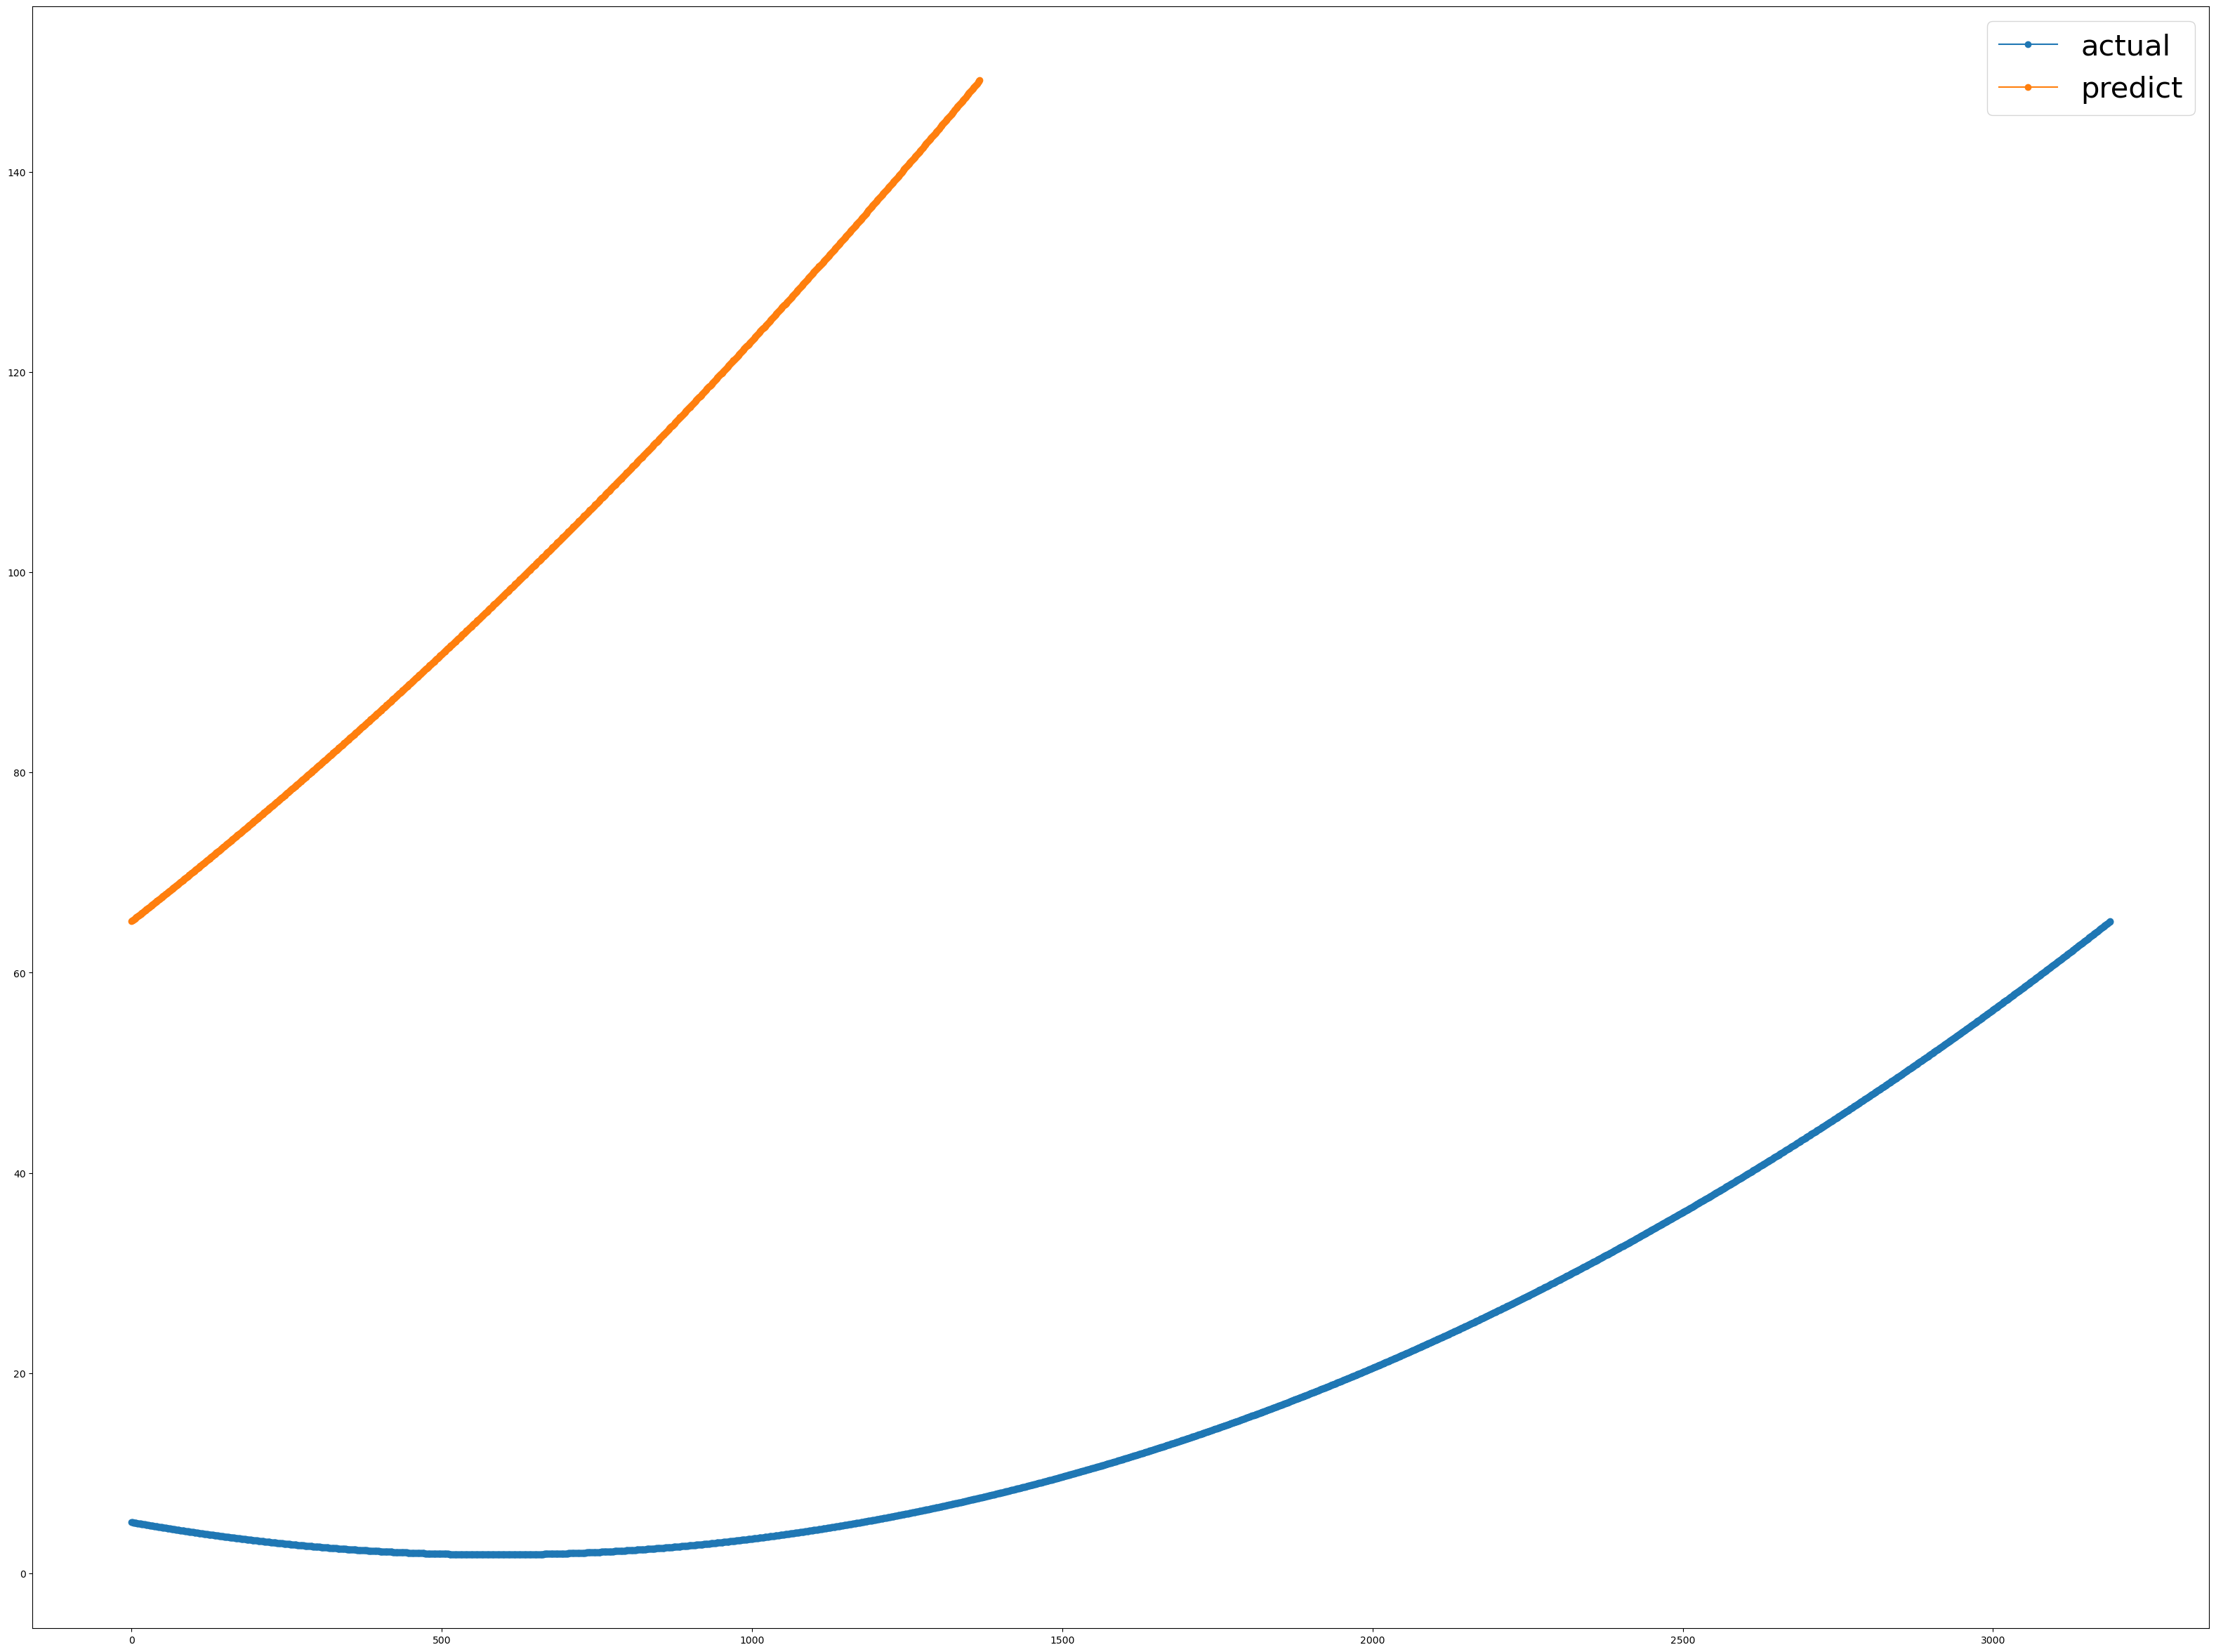

In [38]:
fig, ax1  = plt.subplots(nrows=1)
fig.set_size_inches(40,30)


ax1.plot(trend_train, marker = "o" , label = "actual") # 100일간 데이터 
ax1.plot(trend_test, marker = "o", label = "predict") # 100일간 데이터 
ax1.legend(prop={'size':30})

In [34]:
train_y_delta = train_y - trend_train
test_y_delta = test_y - trend_test

xgb= XGBRegressor()
xgb.fit(train_x, train_y_delta)

xgb_train = xgb.predict(train_x)
xgb_test = xgb.predict(test_x)

# 단일변량

In [4]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [5]:
data

,rsid,name,cnt_item,is_pending,insert_date_time
0,unirs01,recv_smt_slow.que,0,0,2022-09-29 00:00:01
1,unirs01,recv_mmt_slow.que,0,0,2022-09-29 00:00:01
2,unirs01,recv_smt_fast.que,0,0,2022-09-29 00:00:01
3,unirs01,recv_mmt_fast.que,0,0,2022-09-29 00:00:01
4,unirs01,dbmtfail.que,0,0,2022-09-29 00:00:01
...,...,...,...,...,...
155515,wngrs01,dbmt6.que,2,0,2022-09-29 23:59:03
155516,wngrs01,dbmtfail.que,0,0,2022-09-29 23:59:03
155517,wngrs02,dbmtfail.que,0,0,2022-09-29 23:59:03
155518,rcsrs01,recv_mmt_fast.que,0,0,2022-09-29 23:59:03


In [6]:
cnt_item_data3 = data.groupby(["insert_date_time"], as_index=False).sum()
cnt_item_data3

,insert_date_time,cnt_item,is_pending
0,2022-09-29 00:00:01,3,0
1,2022-09-29 00:00:02,6,0
2,2022-09-29 00:01:01,4,0
3,2022-09-29 00:01:02,5,0
4,2022-09-29 00:02:01,4,0
...,...,...,...
4553,2022-09-29 23:58:02,0,0
4554,2022-09-29 23:58:03,0,0
4555,2022-09-29 23:59:01,3,0
4556,2022-09-29 23:59:02,2,0


In [7]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data=[]
    labels=[]
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        #Reshape data from (history_size,) to (history_size,1)
        data.append(np.reshape(dataset[indices], (history_size,1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [8]:
TRAIN_SPLIT = 4000
tf.random.set_seed(13)

In [9]:
uni_data = cnt_item_data3['cnt_item']
uni_data.index = cnt_item_data3['insert_date_time']
uni_data.head()

insert_date_time
2022-09-29 00:00:01    3
2022-09-29 00:00:02    6
2022-09-29 00:01:01    4
2022-09-29 00:01:02    5
2022-09-29 00:02:01    4
Name: cnt_item, dtype: int64

array([<AxesSubplot:xlabel='insert_date_time'>], dtype=object)

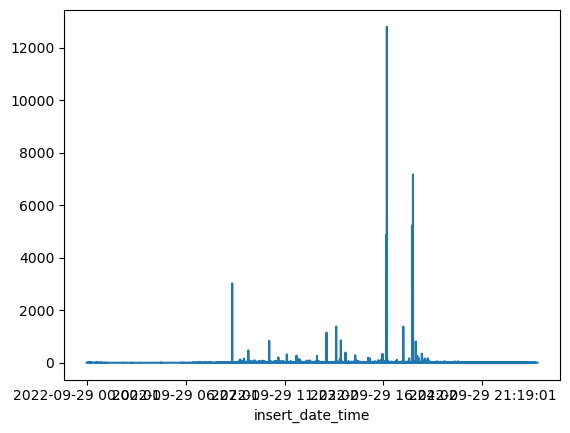

In [10]:
uni_data.plot(subplots=True)

In [11]:
uni_data = uni_data.values

#### 뉴럴 네트워크 모델을 학습하기 전에 각각의 변수들의 비율(Scale)을 맞추는것이 중요
#### 데이터 값에 평균값을 빼고 표준편차를 나누는 데이터 표준화 (Standardization) 과정은 이를 달성하기 위해 가장 많이 사용되는 방식입니다. 케라스 페키지에는 tf.keras.utils.normalize 기능이 포함되어있어 이를 사용하면 데이터값을 [0,1] 범위 안으로 자동적으로 축적

In [12]:
uni_data

array([3, 6, 4, ..., 3, 2, 4])

In [47]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [48]:
uni_data = (uni_data - uni_train_mean)/(uni_train_std)

- 1) 모델 생성에 있어서 가장 최근에 수집된, 마지막 20개의 데이터포인트를 사용해서 미래 온도를 예측

In [51]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT, univariate_past_history, univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None, univariate_past_history, univariate_future_target)

In [52]:
print('Single window of past history')
print(x_train_uni[0])
print('\n Target temperature to predict')
print(y_train_uni[0])

Single window of past history
[[-0.07339942]
 [-0.06273852]
 [-0.06984579]
 [-0.06629216]
 [-0.06984579]
 [-0.05207762]
 [-0.06273852]
 [-0.07695306]
 [-0.07339942]
 [-0.07339942]
 [-0.05207762]
 [-0.05918489]
 [-0.06629216]
 [-0.07695306]
 [-0.06984579]
 [-0.06984579]
 [-0.02009491]
 [-0.05207762]
 [-0.06984579]
 [-0.08050669]]

 Target temperature to predict
-0.030755815164392537


In [53]:
def create_time_steps(length):
    return list(range(-length, 0))

In [54]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0
        
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/envs/info/lib/python3.8/site-packages/matplotlib/pyplot.py'>

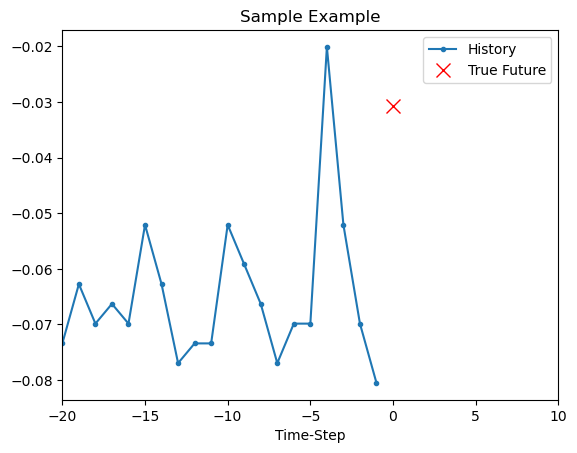

In [55]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

- 2. 베이스라인 모델에서는 모든 과거 데이터 포인트 중 가장 최근에 발생한 20개의 포인트의 평균을 계산

<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/envs/info/lib/python3.8/site-packages/matplotlib/pyplot.py'>

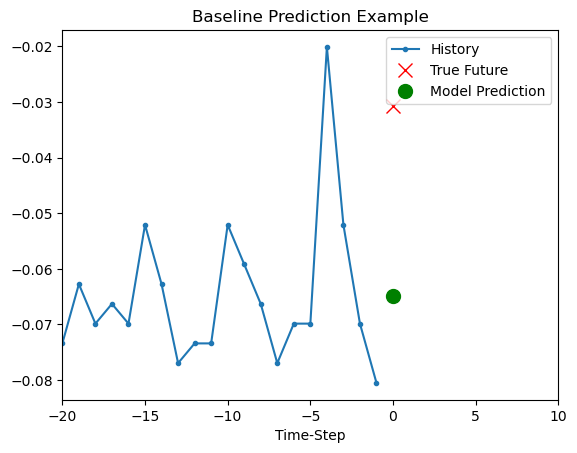

In [56]:
def baseline(history):
    return np.mean(history)

show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Baseline Prediction Example')

- 3. 순환신경망(Recurrent Neural Network)
    - 순환신경망을 통해 시계열 데이터를 한 시점 한시점씩 처리할 수 있으며, 이는 해당 시점까지 인풋으로 들어갔던 데이터를 요약하는 성

In [58]:
BATCH_SIZE = 256
BUFFER_SIZE = 1000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [59]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [60]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [61]:
EVALUATION_INTERVAL = 20 #데이터셋 크기가 큼으로 시간을 절약하기위해서 각 EPOCH는 20스탭만 실시합니다
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_univariate, validation_steps=50)

Epoch 1/10
20/20 [==============================] - 2s 59ms/step - loss: 0.0719 - val_loss: 0.0126
Epoch 2/10
20/20 [==============================] - 1s 37ms/step - loss: 0.0733 - val_loss: 0.0135
Epoch 3/10
20/20 [==============================] - 1s 31ms/step - loss: 0.0929 - val_loss: 0.0125
Epoch 4/10
20/20 [==============================] - 1s 37ms/step - loss: 0.0743 - val_loss: 0.0126
Epoch 5/10
20/20 [==============================] - 1s 44ms/step - loss: 0.0644 - val_loss: 0.0125
Epoch 6/10
20/20 [==============================] - 1s 46ms/step - loss: 0.0669 - val_loss: 0.0129
Epoch 7/10
20/20 [==============================] - 1s 72ms/step - loss: 0.0816 - val_loss: 0.0126
Epoch 8/10
20/20 [==============================] - 1s 47ms/step - loss: 0.0851 - val_loss: 0.0127
Epoch 9/10
20/20 [==============================] - 1s 28ms/step - loss: 0.0635 - val_loss: 0.0125
Epoch 10/10
20/20 [==============================] - 1s 27ms/step - loss: 0.0655 - val_loss: 0.0129


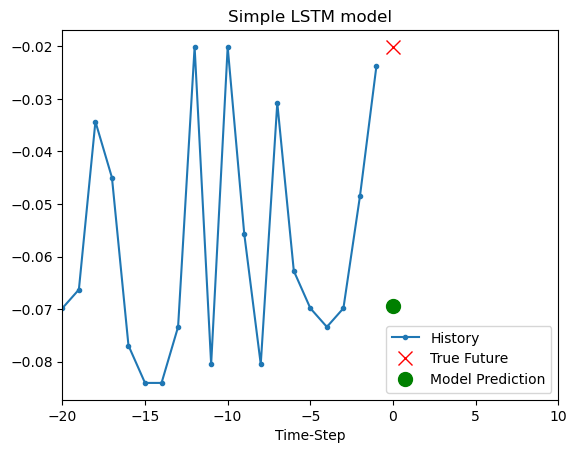

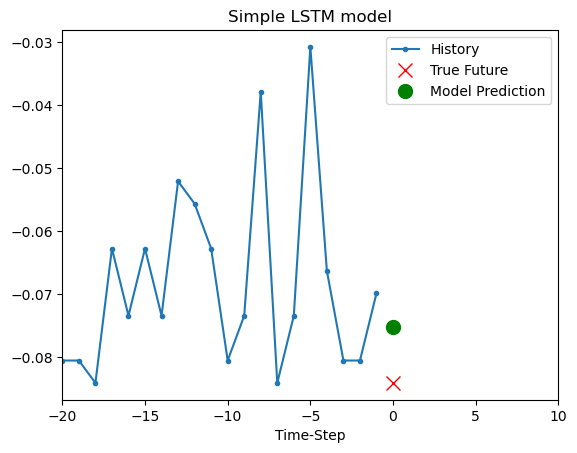

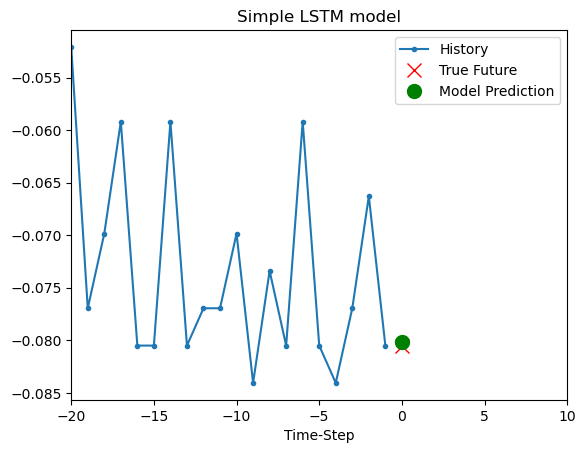

In [62]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(), simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()